In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
sns.set_theme(style="darkgrid")

In [2]:
claims_data = pd.read_csv('claims.csv', parse_dates=[3], infer_datetime_format=True)
cust_data = pd.read_csv('cust_demographics.csv', parse_dates=[2], infer_datetime_format=True)

In [3]:
claims_data.head()

,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,54004764,21868593,Driver error,2017-11-27,Auto,No,Material only,$2980,1.0,No
1,33985796,75740424,Crime,2018-10-03,Home,Unknown,Material only,$2980,3.0,No
2,53522022,30308357,Other driver error,2018-02-02,Auto,No,Material only,$3369.5,1.0,Yes
3,13015401,47830476,Natural causes,2018-06-17,Auto,No,Material only,$1680,1.0,No
4,22890252,19269962,Crime,2018-01-13,Auto,No,Material only,$2680,1.0,No


In [4]:
cust_data.head()

,CUST_ID,gender,DateOfBirth,State,Contact,Segment
0,21868593,Female,1979-01-12,VT,789-916-8172,Platinum
1,75740424,Female,2070-01-13,ME,265-543-1264,Silver
2,30308357,Female,1984-03-11,TN,798-631-4758,Silver
3,47830476,Female,1986-05-01,MA,413-187-7945,Silver
4,19269962,Male,1977-05-13,NV,956-871-8691,Gold


## Correcting the dates, parsed by the read_csv function

In [5]:
def fix_date(x):
    if (x.year > 2000):
        return x.replace(year=x.year-100)
    return x

In [6]:
cust_data.DateOfBirth=cust_data.DateOfBirth.apply(fix_date)

#### Merging the respetive tables and fixing the claim_amount column

In [7]:
df=pd.merge(claims_data, cust_data, left_on='customer_id', right_on='CUST_ID').drop('CUST_ID', axis=1)

In [8]:
df.loc[~df.claim_amount.isna(),'claim_amount']=df[~df.claim_amount.isna()]['claim_amount'].apply(lambda x: float(x[1:]))

In [9]:
df.claim_amount=df.claim_amount.astype('float')

In [10]:
df.police_report.value_counts()

No         621
Unknown    296
Yes        168
Name: police_report, dtype: int64

In [11]:
df.sort_values(by=['customer_id','claim_date'], inplace=True)

#### Retaining the most recent observation and deleting any duplicated records in the data based on the customer ID column

In [12]:
df.drop_duplicates(subset='customer_id', keep='last', inplace=True, ignore_index=True)

#### Filling null values for continuous variables with the mean

In [13]:
for c in df.columns:
    if df[c].isna().sum():
        print(c,": ",df[c].isna().sum())

claim_amount :  65
total_policy_claims :  10


In [14]:
df.claim_amount.fillna(int(df.claim_amount.mean()), inplace=True)

In [15]:
df.total_policy_claims.fillna(int(df.total_policy_claims.mean()), inplace=True)

### Calculating the age and segregating into age based categories

In [16]:
def calculate_age(born):
    born = born.date()
    today = dt.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [17]:
df['Age'] = df.DateOfBirth.apply(calculate_age)

In [18]:
df["Age group"]=pd.cut(df.Age, bins=[0, 17, 30, 60, 150], right=True, labels=['Children', 'Youth', 'Adult', 'Senior'])

### Average amount claimed by the customers from various segments

In [19]:
df.groupby('Segment')['claim_amount'].mean()

Segment
Gold        12846.357143
Platinum    12371.624654
Silver      12267.800578
Name: claim_amount, dtype: float64

In [20]:
df.claim_date=df.claim_date.apply(lambda x: x.date())

### Total claim amount based on incident cause for all the claims that have been done at least 20 days prior to 1st of October, 2018

In [21]:
df[df.claim_date<=(dt.date(2018,10,1)-dt.timedelta(days=20))].groupby('incident_cause')['claim_amount'].sum()

incident_cause
Crime                  721935.0
Driver error          3315842.0
Natural causes        1312980.5
Other causes          3723138.0
Other driver error    3277527.0
Name: claim_amount, dtype: float64

In [24]:
df.incident_cause.value_counts()

Other causes          284
Driver error          259
Other driver error    243
Natural causes        185
Crime                 107
Name: incident_cause, dtype: int64

### Adults from TX, DE and AK that claimed insurance for driver related issues and causes

In [22]:
df[(df['Age group']=='Adult')&(df.incident_cause.isin(['Driver error','Other driver error']))&(df.State.isin(['TX','DE','AK']))].groupby('State').size()

State
AK     8
DE    12
TX     9
dtype: int64

### A pie chart between the aggregated value of claim amount based on gender and segment.

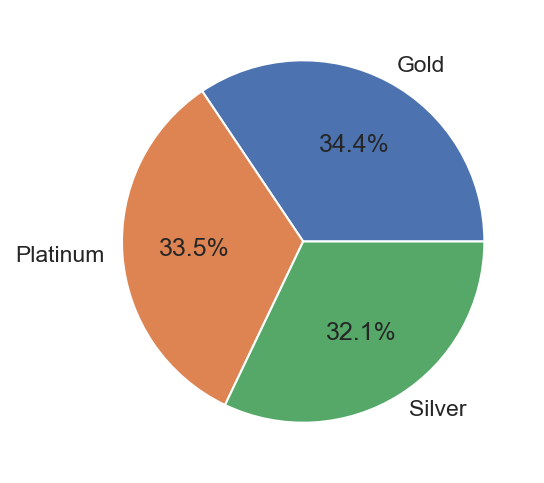

In [23]:
y=df.Segment.value_counts()
plt.figure(dpi=150)
plt.pie(y.values, labels = y.index, autopct='%1.1f%%')
plt.show()

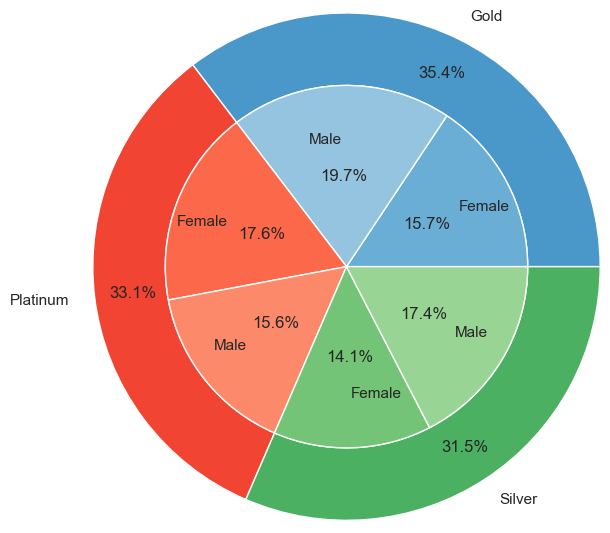

In [24]:
y_seg=df.groupby('Segment')['claim_amount'].sum()
y=df.groupby(['Segment', 'gender'])['claim_amount'].sum()

# Make data: I have 3 groups and 7 subgroups
group_names=y_seg.index.values
group_size=y_seg.values
subgroup_names=[x[1] for x in y.index]
subgroup_size=y.values
 
# Create colors
a, b, c=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
 
# First Ring (outside)
fig, ax = plt.subplots(figsize=[6,6],dpi=100)
mypie, *_ = ax.pie(group_size, radius=1.4, labels=group_names, pctdistance=0.85, colors=[a(0.6), b(0.6), c(0.6)],autopct='%1.1f%%')
plt.setp( mypie, width=0.4, edgecolor='white')
 
# Second Ring (Inside)
mypie2, *_ = ax.pie(subgroup_size, radius=1, labels=subgroup_names, labeldistance=0.7, pctdistance=0.5, colors=[a(0.5), a(0.4), b(0.5), b(0.4), c(0.5), c(0.4)],autopct='%1.1f%%')
#plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)
 
# show it
plt.show()

#### Among males and females, which gender had claimed the most for any type of driver related issues

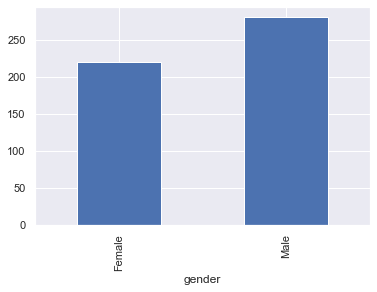

In [25]:
df[df.incident_cause.isin(['Driver error','Other driver error'])].groupby('gender').size().plot.bar()
plt.show()

#### Which age group had the maximum fraudulent policy claims

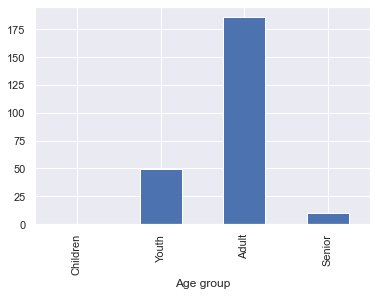

In [26]:
df[df.fraudulent=='Yes'].groupby('Age group').size().plot.bar()
plt.show()

#### Monthly trend of the total amount that has been claimed by the customers.

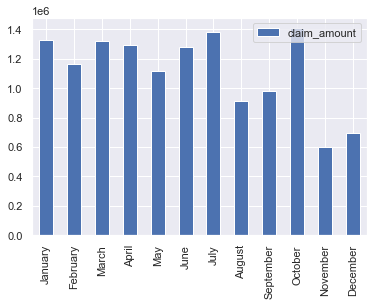

In [27]:
import calendar
months=list(calendar.month_name)[1:]
claim_by_month=pd.DataFrame(df.groupby(df.claim_date.apply(lambda x: x.month))['claim_amount'].sum()).set_index([months],drop=True)
claim_by_month.plot.bar()
plt.show()

### The average claim amount for gender and age categories

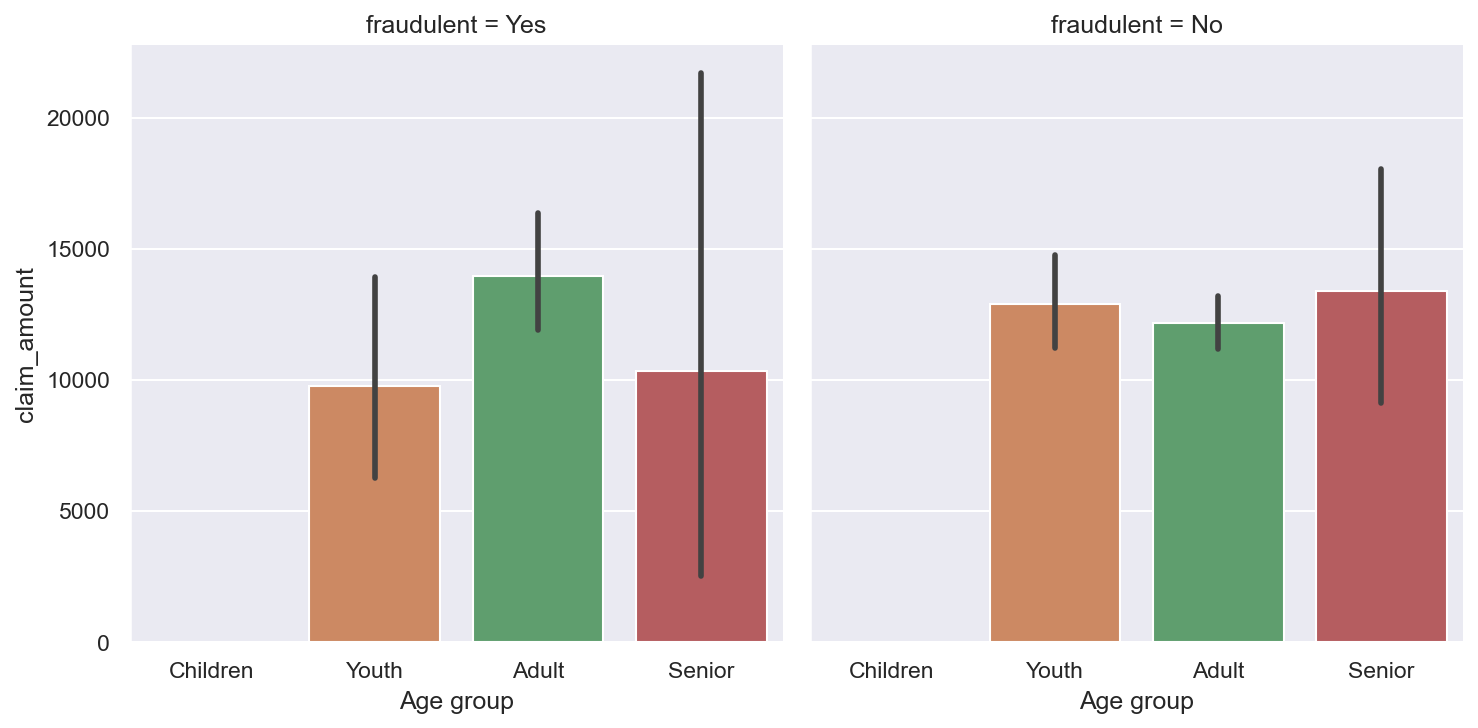

In [28]:
g = sns.catplot(x="Age group", y="claim_amount", col="fraudulent", data=df, kind="bar")
g.figure.dpi=150

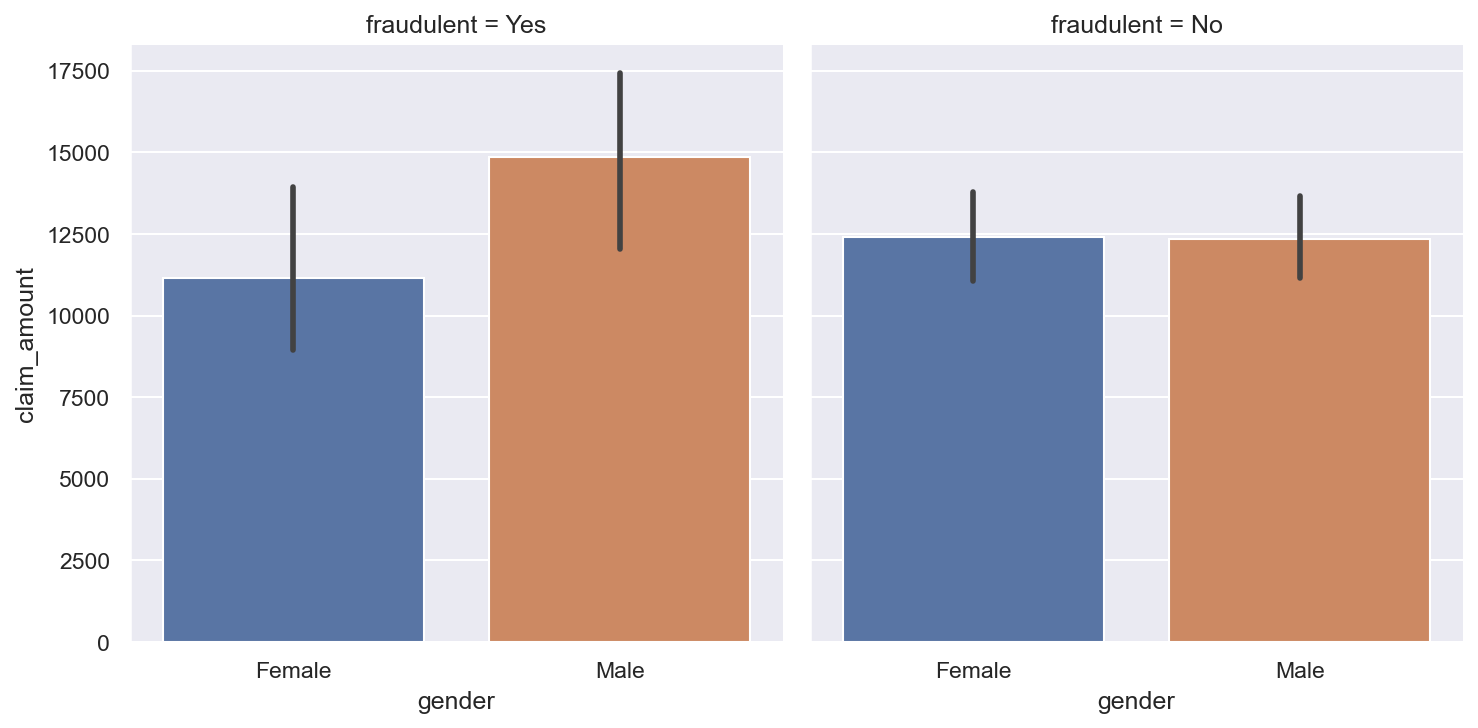

In [29]:
g = sns.catplot(x="gender", y="claim_amount", col="fraudulent", data=df,kind="bar")
g.figure.dpi=150

# A few statistical inferences

## The p-value quantifies the probability of observing as or more extreme values assuming the null hypothesis, that the samples are drawn from populations with the same population means, is true.

In [30]:
from scipy import stats

## Is there any similarity in the amount claimed by males and females?

In [31]:
claim_female=df[df.gender=='Female'].claim_amount
claim_male=df[df.gender=='Male'].claim_amount
stats.ttest_ind(claim_female, claim_male, equal_var=False)


Ttest_indResult(statistic=-0.9631715356388888, pvalue=0.3356778891030502)

#### Based on the above definition of the p value, we can not reject the null hypothesis, hence we concude that the means are much likely to be similar

## Is there any relationship between age category and segment?

In [32]:
pd.crosstab(df['Age group'], df.Segment)

Segment,Gold,Platinum,Silver
Age group,,,
Youth,78,85,83
Adult,284,260,250
Senior,9,16,13


In [33]:
stats.chi2_contingency(pd.crosstab(df['Age group'], df.Segment))

(3.626634620699117,
 0.4588862202576277,
 4,
 array([[ 84.66233766,  82.38033395,  78.95732839],
        [273.25974026, 265.89424861, 254.84601113],
        [ 13.07792208,  12.72541744,  12.19666048]]))

#### A p-value of 0.458 indicates that any categorical distinction among age groups is extremely insignificant

## Test the hypothesis that the current year has shown a significant rise in claim amounts as compared to 2016-17 fiscal average which was 10,000 dolars.

In [34]:
df.claim_amount.mean()

12501.682745825603

In [35]:
stats.ttest_1samp(df.claim_amount, 10000)

Ttest_1sampResult(statistic=6.146789546212883, pvalue=1.1118162749568336e-09)

#### The p-value above indicates that the population mean for claim amount is highly unlikely to be 10000

In [39]:
stats.t.interval(alpha=0.99, df=len(df.claim_amount)-1, loc=df.claim_amount.mean(), scale=stats.sem(df.claim_amount))

(11451.484583713278, 13551.880907937928)

#### Moreover going by the confidence interval approach, we can say with 99% confidence that the true population mean lies in the range stated above, which is far from the hypothesised 10,000

## Is there any difference between age groups and insurance claims?

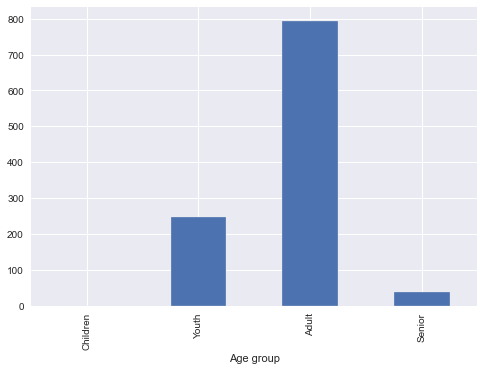

In [252]:
df.groupby('Age group').size().plot.bar()
plt.show()

#### Claims are significantly high among adults

## Is there any relationship between total number of policy claims and the claimed amount?

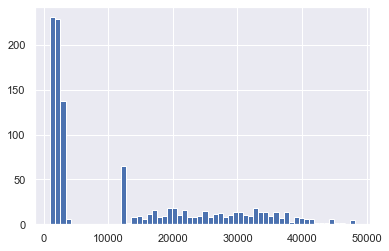

In [40]:
df.claim_amount.hist(bins=60)
plt.show()

In [256]:
df.claim_amount.describe()

count     1078.000000
mean     12501.682746
std      13362.670809
min       1000.000000
25%       1940.875000
50%       2861.000000
75%      22932.500000
max      48150.500000
Name: claim_amount, dtype: float64

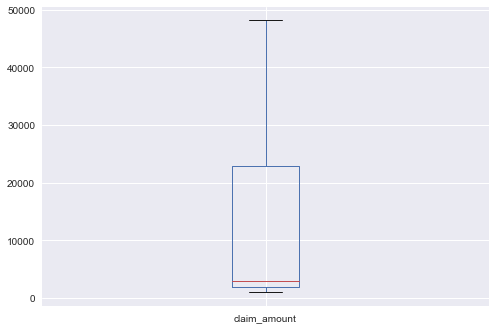

In [260]:
df.boxplot(column='claim_amount')
plt.show()

#### Significant peak in claims with smaller amount, other tools like tableau would better suit for a more accurate and interactive graphical representation